# Предварительный анализ данных
Первым этапом проводится предварительная обработка данных, как в первой лабораторной работе.

In [ ]:
import pandas as pd

In [ ]:
url = "/content/drive/MyDrive/3cancer.csv"
df = pd.read_csv(url,encoding = "utf-8",sep=",")
df.head(5)

,id,clump_thickness,size_uniformity,shape_uniformity,marginal_adhesion,epithelial_size,bare_nucleoli,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 699 non-null    int64 
 1   clump_thickness    699 non-null    int64 
 2   size_uniformity    699 non-null    int64 
 3   shape_uniformity   699 non-null    int64 
 4   marginal_adhesion  699 non-null    int64 
 5   epithelial_size    699 non-null    int64 
 6   bare_nucleoli      699 non-null    object
 7   bland_chromatin    699 non-null    int64 
 8   normal_nucleoli    699 non-null    int64 
 9   mitoses            699 non-null    int64 
 10  class              699 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.2+ KB


In [ ]:
df.columns

Index(['id', 'clump_thickness', 'size_uniformity', 'shape_uniformity',
       'marginal_adhesion', 'epithelial_size', 'bare_nucleoli',
       'bland_chromatin', 'normal_nucleoli', 'mitoses', 'class'],
      dtype='object')

Из набора данных удаляются строки с пустыми значениями и дубликаты. Скрытых дубликатов в наборе не может быть, так как столбцы имеют числовое значение.

In [ ]:
print(df.isna().sum())

id                   0
clump_thickness      0
size_uniformity      0
shape_uniformity     0
marginal_adhesion    0
epithelial_size      0
bare_nucleoli        0
bland_chromatin      0
normal_nucleoli      0
mitoses              0
class                0
dtype: int64


In [ ]:
df = df.drop_duplicates()

Столбец с значением голых ядер имеет тип object, поэтому его тип изменяется на int, предварительно выполнив метод to_numeric с значением "coerce" параметра "errors", чтобы заменить некорректные значения на NaN и удалить их при помощи метода dropna.

In [ ]:
df["bare_nucleoli"] = pd.to_numeric(df["bare_nucleoli"], errors="coerce")
df = df.dropna(subset= ["bare_nucleoli"])
df["bare_nucleoli"] = df["bare_nucleoli"].astype(int)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 675 entries, 0 to 698
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   id                 675 non-null    int64
 1   clump_thickness    675 non-null    int64
 2   size_uniformity    675 non-null    int64
 3   shape_uniformity   675 non-null    int64
 4   marginal_adhesion  675 non-null    int64
 5   epithelial_size    675 non-null    int64
 6   bare_nucleoli      675 non-null    int64
 7   bland_chromatin    675 non-null    int64
 8   normal_nucleoli    675 non-null    int64
 9   mitoses            675 non-null    int64
 10  class              675 non-null    int64
dtypes: int64(11)
memory usage: 63.3 KB


# Кластеризация данных

Вторым этапом выполняется кластеризация данных, для этого сначала выполняется стандартизация набора данных с помощью импортируемого метода StandardScaler библиотеки sklearn.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df.drop(columns= ["id"]))
df_sc = scaler.transform(df.drop(columns= ["id"]))

In [ ]:
df_sc = df_sc[:10]

Затем с помощью метода linkage выполняется иерархически агломеративная кластеризация, в качестве метода подсчёта расстояний между объектами выбирается метод - ward. И при помощи метода dendogram построенная кластеризация отображается в виде дендрограммы. Оба метода импортируются из библиотеки scipy.

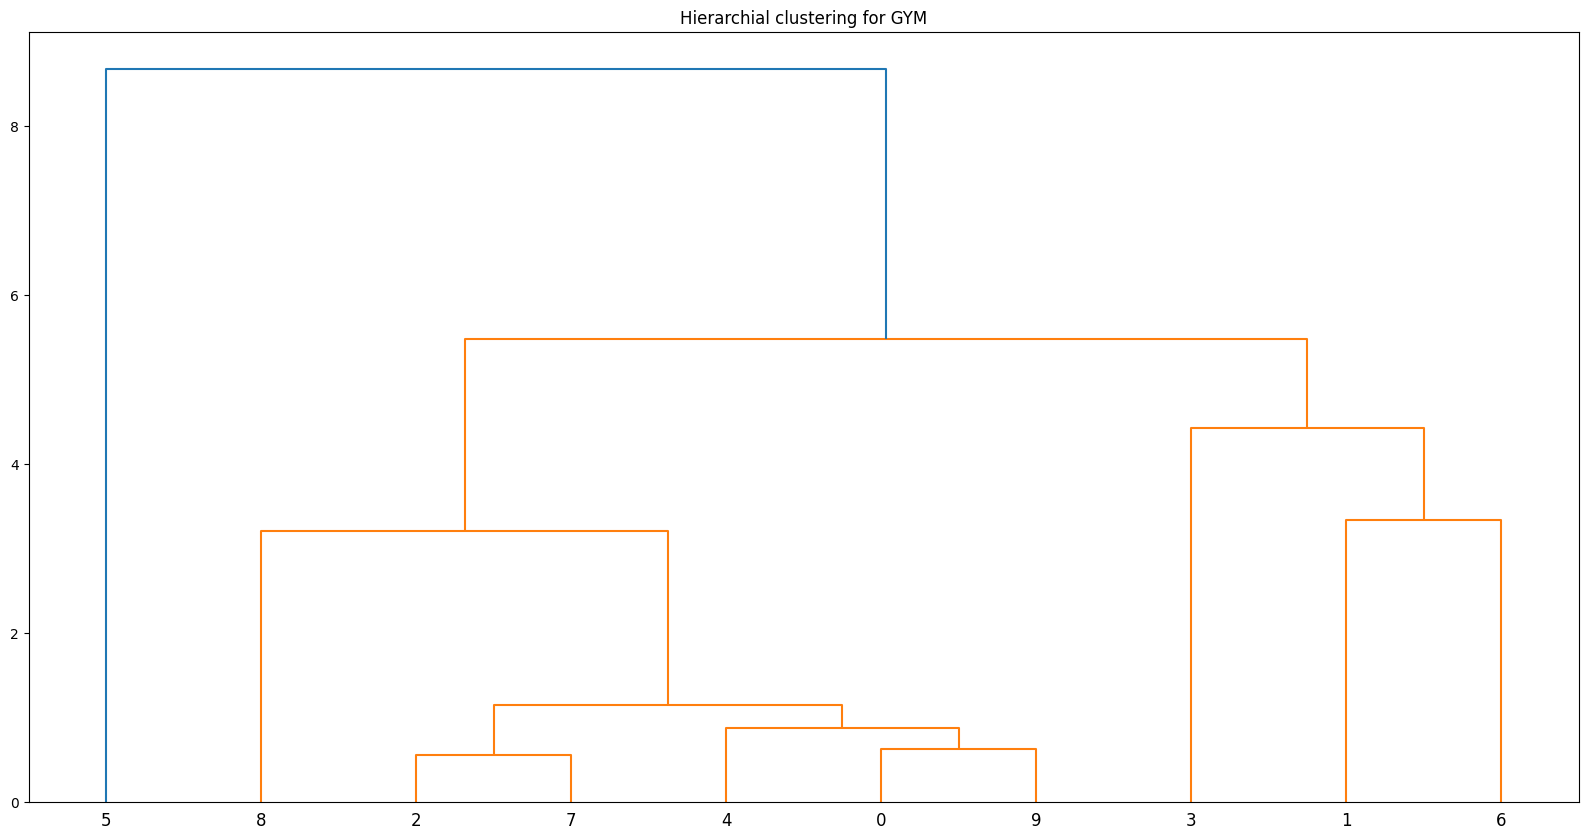

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
linked = linkage(df_sc, method = 'ward')
plt.figure(figsize=(20, 10))
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.show()

In [ ]:
linked

array([[ 2.        ,  7.        ,  0.5608641 ,  2.        ],
       [ 0.        ,  9.        ,  0.63204307,  2.        ],
       [ 4.        , 11.        ,  0.88257989,  3.        ],
       [10.        , 12.        ,  1.15351818,  5.        ],
       [ 8.        , 13.        ,  3.20902689,  6.        ],
       [ 1.        ,  6.        ,  3.34274588,  2.        ],
       [ 3.        , 15.        ,  4.42601616,  3.        ],
       [14.        , 16.        ,  5.48089497,  9.        ],
       [ 5.        , 17.        ,  8.67620165, 10.        ]])

Из дендограммы видно, что оптимальным количеством кластеров будет являться 2, при чем один из них будет значительно больше другого по количеству элементов набора.

После выполняется кластеризация методом k средних. Для этого используется метод KMeans из библиотеки sklearn. Для определения оптимального количества кластеров используется метрика силуэта, которая подсчитывается методом silhouette_score из  библиотеки sklearn.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
for i in range(2, 6):
    km = KMeans(n_clusters=i, random_state=0)
    labels = km.fit_predict(df_sc)
    print(f"Метрика силуэта {round(silhouette_score(df_sc, labels), 3)} для k = {i}")

Метрика силуэта 0.595 для k = 2
Метрика силуэта 0.572 для k = 3
Метрика силуэта 0.526 для k = 4
Метрика силуэта 0.251 для k = 5


Чем ближе метрика силуэта к 1 тем, более оптимальное количество кластеров выбрано. Поэтому для нашего набора это 2 кластера, так как он имеет наибольшее значение метрики.

Затем значения разделяются на два кластера и находится евклидово расстояние между ними, которое показывает, насколько близки значения групп.

In [ ]:
km = KMeans(n_clusters=2, random_state=0)
labels = km.fit_predict(df_sc)
clusters = [[], []]
for i in range(len(labels)):
  if labels[i] == 0:
    clusters[0].append(df_sc[i])
  if labels[i] == 1:
    clusters[1].append(df_sc[i])
cluster_center = km.cluster_centers_

In [ ]:
from scipy.spatial import distance
print(f"Евклидово расстояние между группами 0 и 1 - ", distance.euclidean(cluster_center[0],cluster_center[1]))

Евклидово расстояние между группами 0 и 1 -  5.098027978545621


Находим три признака для каждого кластера, оказавшие максимальное влияние на выделения кластеров, для этого подсчитываем среднее значение для каждого столбца и высчитываем разность между полученным списком и центроидом кластера, после чего выбираются три столбца с наибольшими значениями. Получившиеся значения выводится в виде таблицы для каждого кластера.

In [ ]:
i = 0
def sort_euclidean(x):
    return distance.euclidean(x[1], cluster_center[i])
sort_cl = sorted(enumerate(clusters[0]), reverse= True , key= sort_euclidean)[:3]
index = [[], []]
for el in sort_cl:
    index[0].append(el[0])
i = 1
sort_cl = sorted(enumerate(clusters[1]), reverse= True , key= sort_euclidean)[:3]
for el in sort_cl:
    index[1].append(el[0])
(index[0], index[1])

([224, 185, 126], [434, 82, 68])

In [ ]:
clusters_attribute = [[], []]
for i in index[0]:
    clusters_attribute[0].append(distance.euclidean(df_sc[i], cluster_center[0]))

for i in index[1]:
    clusters_attribute[1].append(distance.euclidean(df_sc[i], cluster_center[1]))


pd.DataFrame([clusters_attribute[0]], columns= index[0])

,224,185,126
0,1.511262,3.326845,2.636635


In [ ]:
pd.DataFrame([clusters_attribute[1]], columns= index[1])

,434,82,68
0,3.565554,7.089023,0.922269


Метрика силуэта для метода k средних и иерархически агломеративный метод показали, что данный набор данных о параметрах опухоли оптимально разделить на 2 кластера. Это может быть связанно с тем, что целевой признак может принимать два значения: доброкачественная или злокачественная опухоль.

В результате кластеризации набора данных, было определенно, что два кластера является оптимальным количеством для этого набора данных о типе опухоли.

В результате выполнения работы были изучены принципы работы метода k-средних и иерархически агломеративного метода. Используя данные методы, были распределены данные по кластерам, основываясь ни их близости друг к другу. Изучен способ визуализации связи между элементами с помощью дендрограмм. А также был написан алгоритм для вывода трёх признаков, повлиявших на формирование кластеров.

# Дополнительное задание

Определить количество кластеров набора данных без целевого признака. Для этого из набора при стандартизации данных убирается столбец с типом опухоли.

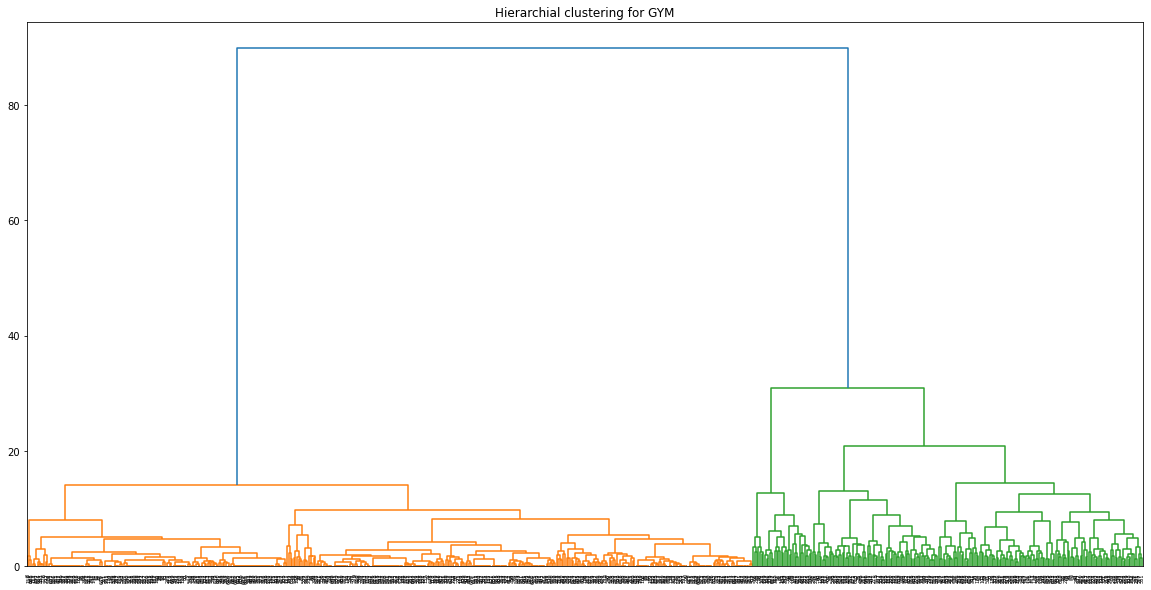

In [ ]:
scaler = StandardScaler()
scaler.fit(df.drop(columns= ["id", "class"]))
df_sc = scaler.transform(df.drop(columns= ["id", "class"]))
linked = linkage(df_sc, method = 'ward')
plt.figure(figsize=(20, 10))
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.show()

Из получившейся дендограммы видно, что наличие целевого признака не влияет на оптимальное количество кластеров.

Следующая часть дополнительного задания добавить столбец с номерами кластеров в набор данных и получить средние значения парметров для каждого кластера.

In [ ]:
df.insert(loc=11,column="claster", value=labels)
df

,id,clump_thickness,size_uniformity,shape_uniformity,marginal_adhesion,epithelial_size,bare_nucleoli,bland_chromatin,normal_nucleoli,mitoses,class,claster
0,1000025,5,1,1,1,2,1,3,1,1,2,1
1,1002945,5,4,4,5,7,10,3,2,1,2,0
2,1015425,3,1,1,1,2,2,3,1,1,2,1
3,1016277,6,8,8,1,3,4,3,7,1,2,0
4,1017023,4,1,1,3,2,1,3,1,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
694,776715,3,1,1,1,3,2,1,1,1,2,1
695,841769,2,1,1,1,2,1,1,1,1,2,1
696,888820,5,10,10,3,7,3,8,10,2,4,0
697,897471,4,8,6,4,3,4,10,6,1,4,0


In [ ]:
data_pivot = df.pivot_table(index= ["claster"], aggfunc="mean",
                            values= ['clump_thickness', 'size_uniformity', 'shape_uniformity',
                                     'marginal_adhesion', 'epithelial_size', 'bare_nucleoli',
                                     'bland_chromatin', 'normal_nucleoli', 'mitoses', 'class'])
data_pivot.round(2)

,bare_nucleoli,bland_chromatin,class,clump_thickness,epithelial_size,marginal_adhesion,mitoses,normal_nucleoli,shape_uniformity,size_uniformity
claster,,,,,,,,,,
0,7.71,6.04,3.94,7.22,5.39,5.69,2.62,5.97,6.63,6.67
1,1.31,2.06,2.04,2.98,2.08,1.33,1.07,1.24,1.38,1.26


Из построенной сводной таблицы видно, что в первом кластере находятся строки с злокачественным типом опухоли, а во втором с доброкачественным. Также значения в столбцах: bare_nucleoli, bland_chromatin, clump_thickness, epithelial_size, marginal_adhesion, normal_nucleoli, shape_uniformity, size_uniformity - в среднем больше в первом кластере, чем во втором, что может говорить о связи этих параметров с целевым признаком. Столбец mitoses не сильно отличается для двух кластеров, но для первого все же больше, чем для второго, что может указывать на наличие слабой связи между этим параметром и типом опухоли.